# Drift Diffusion Models

 # First passage time distribution, prob of hitting a bound
 ![fptd.png](./images/fptd.png)~~
 


# First passage time distribution
https://math.stackexchange.com/questions/1053294/density-of-first-hitting-time-of-brownian-motion-with-drift

![stack overflow](./images/fptd_short.png)

# Prob of hitting lower bound
![](./images/p_hit.png)

In [1]:
import numpy as np
from tqdm import tqdm
import multiprocessing as mp

import matplotlib.pyplot as plt
from scipy.stats import norm

In [2]:
w = 0 # starting pt. 
a = 10 # up boundary 
v = 2 # drift vel
dt = 1e-5; dB = dt**0.5

In [3]:
def simulate_one_trial(w, a, v, dt, dB):
    DV = w # decision var
    t = 0 # time
    while DV <= a:
        DV += v*dt + np.random.normal(0,1)*dB # sigma = 1 implicit
        t += 1
    return t*dt

In [4]:

num_cores = mp.cpu_count()
with mp.Pool(processes=num_cores) as pool:
    RT_arr = pool.starmap(simulate_one_trial, [(w, a, v, dt, dB) for _ in range(500)])

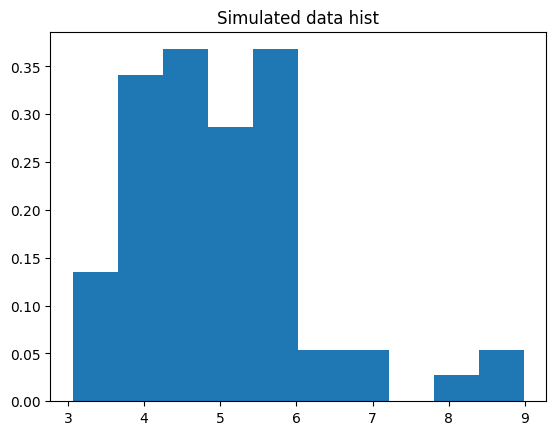

In [6]:
plt.hist(RT_arr, density=True); plt.title('Simulated data hist');

In [7]:
def ftpd(a,c,t):
    return a*np.exp((-(a-c*t)**2)/(2*t))*(1/np.sqrt(2*np.pi*(t**3)))
    

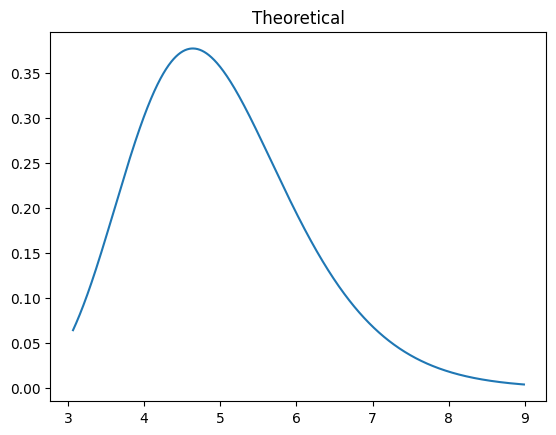

In [8]:
t_vals = np.linspace(min(RT_arr), max(RT_arr), 1000)

prob_t = [ftpd(a,v,t) for t in t_vals]
# prob_t = [x/sum(prob_t) for x in prob_t]

plt.plot(t_vals, prob_t); plt.title('Theoretical');

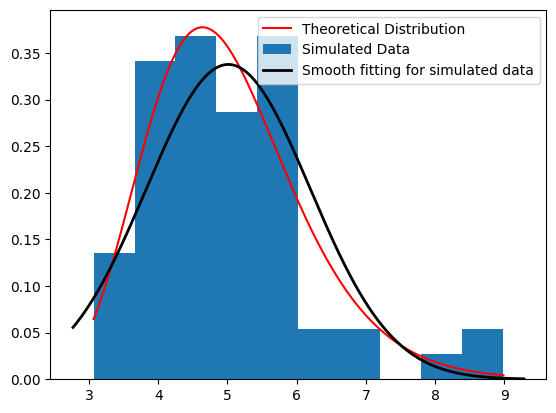

In [9]:


plt.plot(t_vals, prob_t, label='Theoretical Distribution', color='red');
plt.hist(RT_arr, label='Simulated Data', density=True);

xmin, xmax = plt.xlim()
x = np.linspace(xmin, xmax, 1000)
mu, std = norm.fit(RT_arr)
p = norm.pdf(x, mu, std)
plt.plot(x, p, 'k', linewidth=2, label = 'Smooth fitting for simulated data')

plt.legend();



BADS

In [10]:
from pybads import BADS

In [11]:
t = np.array(RT_arr.copy())


In [12]:
def target_func(params):
    a,c = params # upper bound, drift
    return np.sum(-np.log(a*np.exp((-(a-c*t)**2)/(2*t))*(1/np.sqrt(2*np.pi*(t**3)))))

In [13]:
# actual: a=10, c = 2. 
lower_bounds = np.array([1, -5]) 
upper_bounds = np.array([15, 5])
plausible_lower_bounds = np.array([2, 1e-3])
plausible_upper_bounds = np.array([13, 5])
x0 = np.array([2.2, 0.1]); 

In [14]:
options = {
    "max_iter": 2000, 
    "max_fun_evals": 2000
}

bads = BADS(target_func, x0, lower_bounds, upper_bounds, plausible_lower_bounds, plausible_upper_bounds, options=options)
optimize_result = bads.optimize()

bads:TooCloseBounds: For each variable, hard and plausible bounds should not be too close. Moving plausible bounds.
Beginning optimization of a DETERMINISTIC objective function

 Iteration    f-count         f(x)           MeshScale          Method             Actions
     0           2         1410.59               1                                 Uncertainty test
     0           6         819.416               1         Initial mesh            Initial points
     0           9         819.416             0.5         Refine grid             Train
     1          17         819.416            0.25         Refine grid             Train
     2          18         744.677            0.25     Successful search (ES-ell)        
     2          19         744.487            0.25     Successful search (ES-ell)        
     2          20         744.487            0.25     Incremental search (ES-wcm)        
     2          22         744.484            0.25     Incremental search (ES-wcm)  

In [15]:
x_min = optimize_result['x']
x_min# 10, 2

array([10.07936287,  2.01076707])

# Dynesty

In [16]:
from dynesty import NestedSampler
      
from dynesty import plotting as dyplot

In [17]:
def log_like(params):
    a,c = params # upper bound, drift
    return np.sum(np.log(a*np.exp((-(a-c*t)**2)/(2*t))*(1/np.sqrt(2*np.pi*(t**3)))))

In [18]:
def transform_random_number(u, a, b):
    return (b-a)*u + a 


In [19]:
def prior_transform(u):
    # u ~ uniform [0,1]
    priors = np.array(u)

    # a: 0 to 20
    priors[0] =  transform_random_number(u[0], 0.1, 20)


    # c: -5 to 5
    priors[1] = transform_random_number(u[1], -5, 5)

    return priors

In [20]:
ndim = 2
# sampler = NestedSampler(log_likelihood, prior_transform, ndim)
sampler = NestedSampler(log_like, prior_transform, ndim, nlive = 1000)

8635it [00:08, 1054.72it/s, +1000 | bound: 6 | nc: 1 | ncall: 44658 | eff(%): 22.069 | loglstar:   -inf < -744.484 <    inf | logz: -752.884 +/-  0.087 | dlogz:  0.001 >  1.009]


In [22]:
results = sampler.results
results.samples[:,0].mean(), results.samples[:,1].mean() # 10, 2


(10.151566577396059, 1.768018450197534)

(9635, 2)
(9635,)


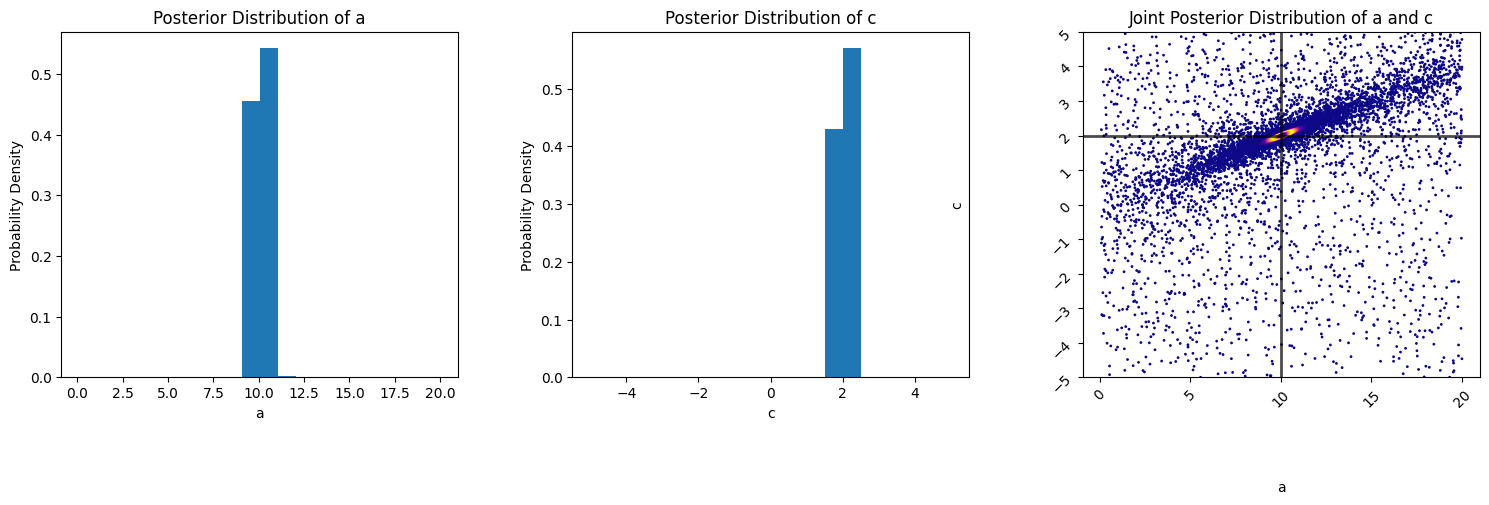

In [23]:

samples = results.samples
print(samples.shape) # (10886, 2)

weights = results.importance_weights()
print(weights.shape)

fig, axes = plt.subplots(1, 3, figsize=(15, 5))

# Plot mu distribution
axes[0].hist(samples[:, 0], weights=weights, bins=20) # Use plt.hist here
axes[0].set_xlabel('a')
axes[0].set_ylabel('Probability Density')
axes[0].set_title('Posterior Distribution of a')

# Plot sigma distribution
axes[1].hist(samples[:, 1], weights=weights, bins=20) # Use plt.hist here
axes[1].set_xlabel('c')
axes[1].set_ylabel('Probability Density')
axes[1].set_title('Posterior Distribution of c')

# Plot joint distribution of mu and sigma
dyplot.cornerpoints(results, kde=True, fig=(fig, axes[2]), truths=[10,2], truth_color='black')
axes[2].set_xlabel('a')
axes[2].set_ylabel('c')
axes[2].set_title('Joint Posterior Distribution of a and c')
axes[2].set_yticks(np.arange(-5, 6, 1))
axes[2].set_ylim(-5, 5)

plt.tight_layout()
plt.show()

# VBMC

In [24]:
from pyvbmc import VBMC
from scipy import stats

In [25]:
a_prior = stats.uniform(0.1,20)
c_prior = stats.uniform(-5, 10);

In [26]:
def log_prior(params):
    a, c = params
    log_prior_a = a_prior.logpdf(a)
    log_prior_c = c_prior.logpdf(c)
    return log_prior_a + log_prior_c

In [27]:
def log_joint(params):
    return log_like(params) + log_prior(params)

In [28]:
vbmc = VBMC(log_joint, x0, lower_bounds, upper_bounds, plausible_lower_bounds, plausible_upper_bounds)
# bads = BADS(target_func, x0, lower_bounds, upper_bounds, plausible_lower_bounds, plausible_upper_bounds, options=options)
vp, results = vbmc.optimize()


Reshaping x0 to row vector.
Reshaping lower bounds to (1, 2).
Reshaping upper bounds to (1, 2).
Reshaping plausible lower bounds to (1, 2).
Reshaping plausible upper bounds to (1, 2).
Casting lower bounds to floating point.
Casting upper bounds to floating point.
Casting plausible upper bounds to floating point.
vbmc:TooCloseBounds: For each variable, hard and plausible bounds should not be too close. Moving plausible bounds.
Beginning variational optimization assuming EXACT observations of the log-joint.
 Iteration  f-count    Mean[ELBO]    Std[ELBO]    sKL-iter[q]   K[q]  Convergence  Action
     0         10        -552.80      1533.38 79868867214726848.00        2        inf     start warm-up
     1         15        -752.28         0.68       112.22        2        inf     
     2         20        -753.68         0.05         1.60        2       42.5     
     3         25        -753.65         0.00         0.01        2      0.319     
     4         30        -753.65         0

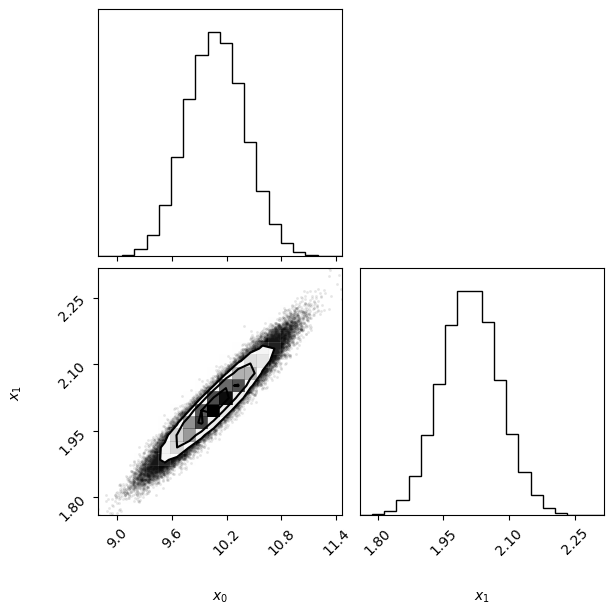

In [29]:
vp.plot();

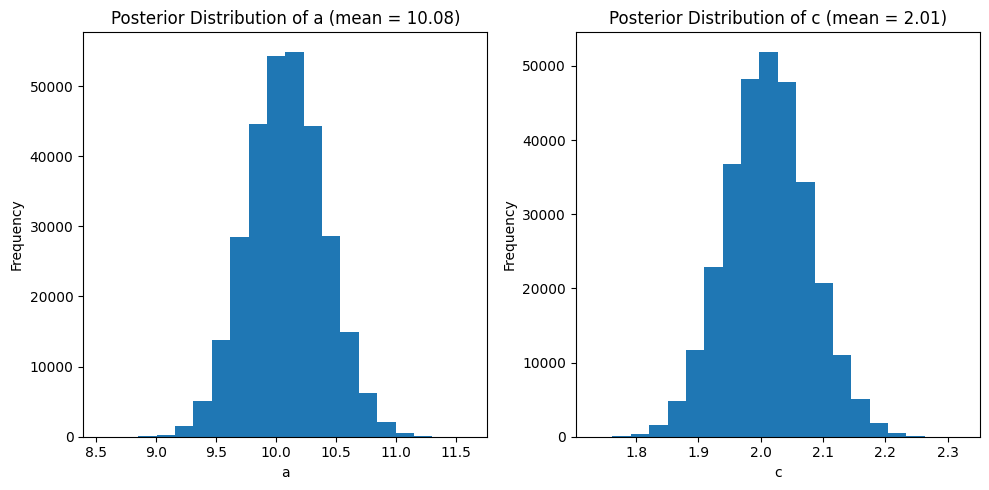

In [30]:
a_c, _ = vp.sample(int(3e5))
a_post = a_c[:,0]
c_post = a_c[:,1]

plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.hist(a_post, bins=20)
plt.title(f'Posterior Distribution of a (mean = {np.mean(a_post):.2f})')
plt.xlabel('a')
plt.ylabel('Frequency')

plt.subplot(1, 2, 2)
plt.hist(c_post, bins=20)
plt.title(f'Posterior Distribution of c (mean = {np.mean(c_post):.2f})')
plt.xlabel('c')
plt.ylabel('Frequency')

plt.tight_layout()
plt.show()


# 3 Param model

In [31]:
starting_pt = 5 # starting pt
a = 10 # up boundary 
w = starting_pt/a # starting pt relative to boundary
v = 1 # drift vel
dt = 1e-5; dB = dt**0.5

In [32]:
def simulate_one_trial(w, a, v, dt, dB):
    DV = w # decision var
    t = 0 # time
    while DV <= a:
        DV += v*dt + np.random.normal(0,1)*dB # sigma = 1 implicit
        t += 1
    return t*dt

In [33]:
num_cores = mp.cpu_count()
with mp.Pool(processes=num_cores) as pool:
    RT_arr = pool.starmap(simulate_one_trial, [(starting_pt, a, v, dt, dB) for _ in range(500)])

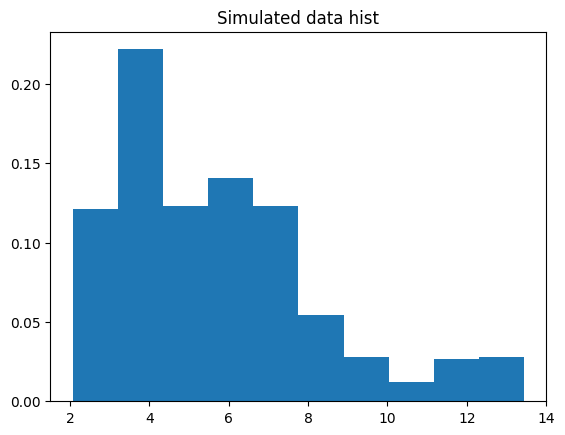

In [35]:
plt.hist(RT_arr, density=True); plt.title('Simulated data hist');

In [194]:
def ftpd_3(v,a,w,t):
    term1 = ((np.pi)/(a**2))*np.exp(v*a*w-(v**2 * t/2))
    term2 = [ k * np.exp(-(k**2 * np.pi**2 * t)/(2 * a**2)) * np.sin(k*np.pi*w) for k in range(1,100) ]
    return term1*np.sum(term2)



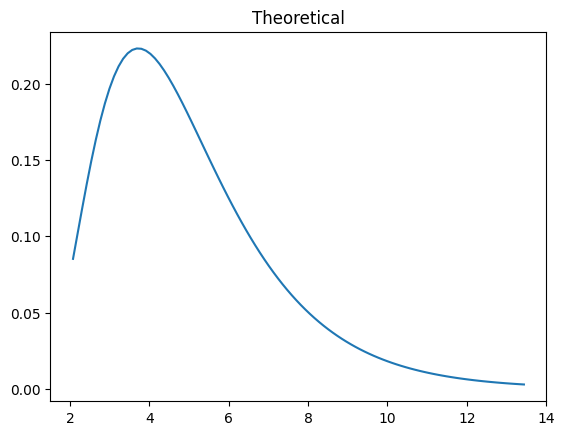

In [37]:
t_vals = np.linspace(min(RT_arr), max(RT_arr), 100)

prob_t = [ftpd_3(v, a, 1-w, t) for t in t_vals]
# prob_t = [x/sum(prob_t) for x in prob_t]

plt.plot(t_vals, prob_t); plt.title('Theoretical');

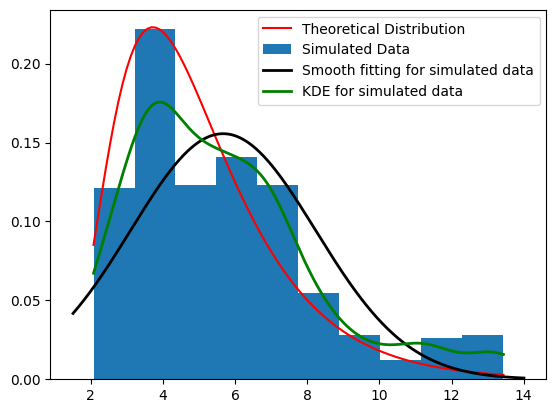

In [38]:


plt.plot(t_vals, prob_t, label='Theoretical Distribution', color='red');
plt.hist(RT_arr, label='Simulated Data', density=True);

xmin, xmax = plt.xlim()
x = np.linspace(xmin, xmax, 1000)
mu, std = norm.fit(RT_arr)
p = norm.pdf(x, mu, std)
plt.plot(x, p, 'k', linewidth=2, label = 'Smooth fitting for simulated data')

from scipy.stats import gaussian_kde
kde = gaussian_kde(RT_arr)
x = np.linspace(min(RT_arr), max(RT_arr), 1000)
plt.plot(x, kde(x), 'g', linewidth=2, label = 'KDE for simulated data')


plt.legend();



# Dynesty on 3 params

In [128]:
t = np.array(RT_arr.copy())

In [195]:
# def log_like(params):
#     v,a,w = params
#     term1 = ((np.pi)/(a**2))*np.exp(v*a*w-(v**2 * t/2))
#     term2 = [ k * np.exp(-(k**2 * np.pi**2 * t)/(2 * a**2)) * np.sin(k*np.pi*w) for k in range(1,10) ]
#     # plt.plot(term1*np.sum(term2));
#     return np.sum(np.log(term1*np.sum(term2)))

# print(log_like([1,10,0.5])) # 2030.8
import sys

def log_like2(params):
    v,a,w = params
    likeli_arr = []
    for time_val in t:
        term1 = ((np.pi)/(a**2))*np.exp(v*a*w-(v**2 * time_val/2))
        term2 = [ k * np.exp(-(k**2 * np.pi**2 * time_val)/(2 * a**2)) * np.sin(k*np.pi*w) for k in range(1,100) ]
        if np.sum(term2) <= 0:
            print('term2 sum ',np.sum(term2),'v=',v,'a=',a,'w=',w,'t=', time_val)
            sys.exit()
    
        likeli_arr.append(term1*np.sum(term2))

    
    return np.sum(np.log(likeli_arr))


-1136.0090659480843 -1136.0090659480843


In [191]:
def prior_transform(u):
    # u ~ uniform [0,1]
    priors = np.array(u)

    # v:  1
    priors[0] =  transform_random_number(u[0], 0.5, 1.5)


    # a:  10
    priors[1] = transform_random_number(u[1], 8, 12)

    
    # w:  0.5
    priors[2] = transform_random_number(u[2], 0.3, 0.7)

    return priors

In [192]:
ndim = 3
# sampler = NestedSampler(log_likelihood, prior_transform, ndim)
sampler = NestedSampler(log_like2, prior_transform, ndim)

In [193]:
sampler.run_nested()

3291it [50:02,  1.10it/s, +500 | bound: 6 | nc: 1 | ncall: 22958 | eff(%): 16.880 | loglstar:   -inf < -1115.638 <    inf | logz: -1121.400 +/-  0.100 | dlogz:  0.001 >  0.509]


In [196]:
results = sampler.results
results.samples[:,0].mean(), results.samples[:,1].mean(),results.samples[:,2].mean()  # 1, 10, 0.5

(0.9279529176812579, 10.06056843099918, 0.5145601286922972)

(3791, 3)
(3791,)


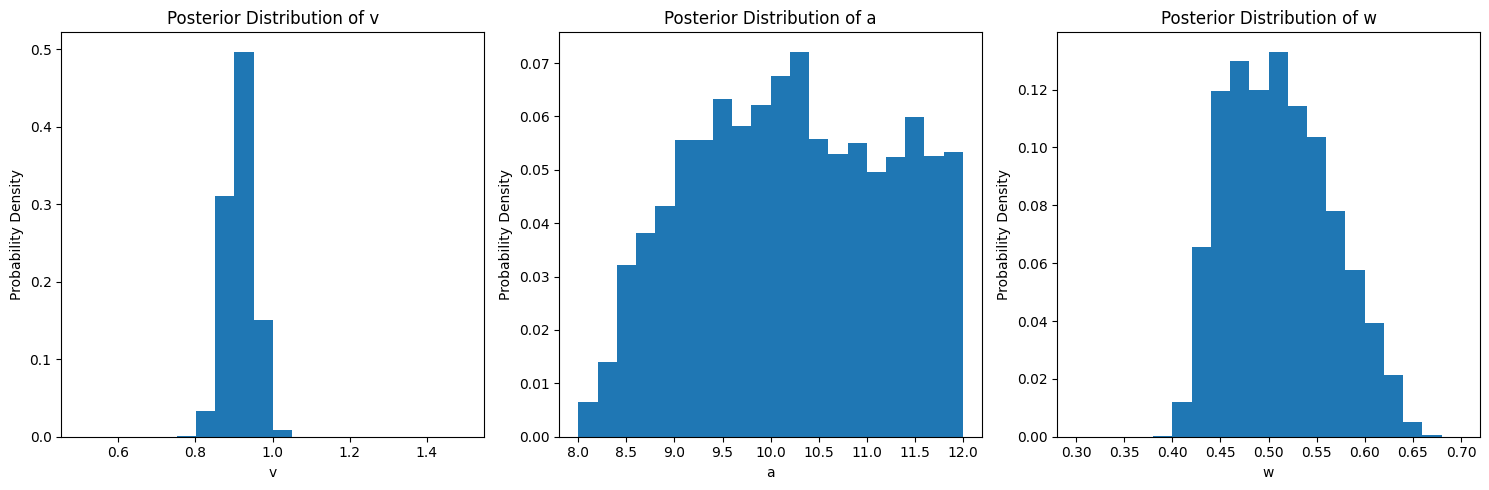

In [197]:
samples = results.samples
print(samples.shape) # (10886, 3)

weights = results.importance_weights()
print(weights.shape)

fig, axes = plt.subplots(1, 3, figsize=(15, 5))

# Plot v distribution
axes[0].hist(samples[:, 0], weights=weights, bins=20) # Use plt.hist here
axes[0].set_xlabel('v')
axes[0].set_ylabel('Probability Density')
axes[0].set_title('Posterior Distribution of v')

# Plot a distribution
axes[1].hist(samples[:, 1], weights=weights, bins=20) # Use plt.hist here
axes[1].set_xlabel('a')
axes[1].set_ylabel('Probability Density')
axes[1].set_title('Posterior Distribution of a')

# Plot w distribution
axes[2].hist(samples[:, 2], weights=weights, bins=20) # Use plt.hist here
axes[2].set_xlabel('w')
axes[2].set_ylabel('Probability Density')
axes[2].set_title('Posterior Distribution of w')

plt.tight_layout()
plt.show()

# BADS

In [231]:
def target_func(params):
    v,a,w = params
    likeli_arr = []
    for time_val in t:
        term1 = ((np.pi)/(a**2))*np.exp(v*a*w-(v**2 * time_val/2))
        term2 = [ k * np.exp(-(k**2 * np.pi**2 * time_val)/(2 * a**2)) * np.sin(k*np.pi*w) for k in range(1,100) ]
        if np.sum(term2) <= 0:
            print('term2 sum ',np.sum(term2),'v=',v,'a=',a,'w=',w,'t=', time_val)
            sys.exit()
    
        likeli_arr.append(term1*np.sum(term2))

    
    return -np.sum(np.log(likeli_arr))



In [232]:
# actual: v,a,w: 1, 10, 0.5. 
lower_bounds = np.array([0.1, 7, 0.2]) 
upper_bounds = np.array([3, 13, 0.8])
plausible_lower_bounds = np.array([0.2, 8, 0.25])
plausible_upper_bounds = np.array([2.8, 12.5, 0.75])
x0 = np.array([0.25, 12, 0.7]); 

In [235]:
options = {
    "max_iter": 10000, 
    "max_fun_evals": 20000,
    'display': 'off',
}

bads = BADS(target_func, x0, lower_bounds, upper_bounds, plausible_lower_bounds, plausible_upper_bounds, options=options)
optimize_result = bads.optimize()

In [234]:
x_min = optimize_result['x']
x_min #1, 10, 0.5

array([ 0.91451238, 12.79302986,  0.40521446])

# VBMC

In [205]:
t = np.array(RT_arr.copy())

In [206]:
a_prior = stats.uniform(8,12)
v_prior = stats.uniform(0.1, 2)
w_prior = stats.uniform(0.1,0.9)

In [209]:
def log_prior(params):
    v,a,w = params
    log_prior_v = v_prior.logpdf(v)
    log_prior_a = a_prior.logpdf(a)
    log_prior_w = w_prior.logpdf(w)
    # print('priors ',  log_prior_v, log_prior_a, 'log prior w =',log_prior_w, 'w=',w)
    return log_prior_v + log_prior_a + log_prior_w


In [223]:
def log_like(params):
    v,a,w = params
    likeli_arr = []
    for time_val in t:
        term1 = ((np.pi)/(a**2))*np.exp(v*a*w-(v**2 * time_val/2))
        term2 = [ k * np.exp(-(k**2 * np.pi**2 * time_val)/(2 * a**2)) * np.sin(k*np.pi*w) for k in range(1,100) ]
        if np.sum(term2) <= 0:
            print('term2 sum ',np.sum(term2),'v=',v,'a=',a,'w=',w,'t=', time_val)
            sys.exit()
    
        likeli_arr.append(term1*np.sum(term2))

    
    return np.sum(np.log(likeli_arr))

In [214]:
def log_joint(params):
    # print('joint ', log_like(params) + log_prior(params))
    return log_like(params) + log_prior(params)

In [226]:
# actual: v,a,w: 1, 10, 0.5. 
lower_bounds = np.array([0.5, 8, 0.2]) 
upper_bounds = np.array([2, 12, 0.8])
plausible_lower_bounds = np.array([0.6, 9, 0.25])
plausible_upper_bounds = np.array([1.9, 11, 0.75])



x0 = np.array([0.7, 9.1, 0.7])


In [227]:
options = {'display': 'off'}
vbmc = VBMC(log_joint, x0, lower_bounds, upper_bounds, plausible_lower_bounds, plausible_upper_bounds, options=options)
# bads = BADS(target_func, x0, lower_bounds, upper_bounds, plausible_lower_bounds, plausible_upper_bounds, options=options)
vp, results = vbmc.optimize()


Reshaping x0 to row vector.
Reshaping lower bounds to (1, 3).
Reshaping upper bounds to (1, 3).
Reshaping plausible lower bounds to (1, 3).
Reshaping plausible upper bounds to (1, 3).
Inference terminated: variational solution stable for options.tol_stable_count fcn evaluations.
Estimated ELBO: -1123.927 +/-0.001.


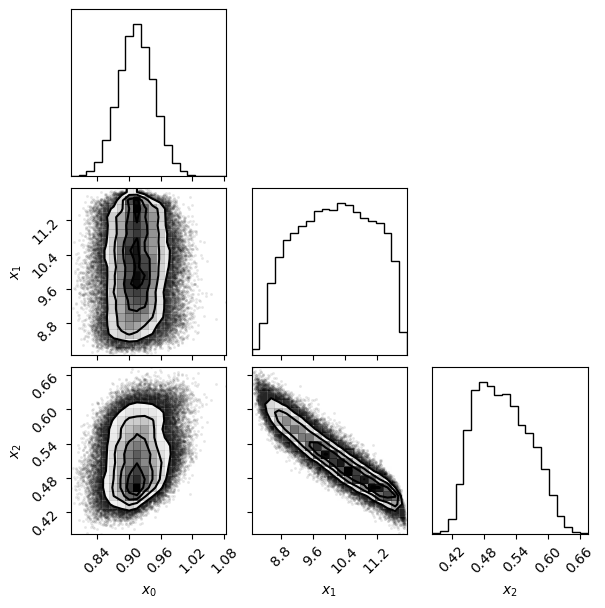

In [228]:
vp.plot();

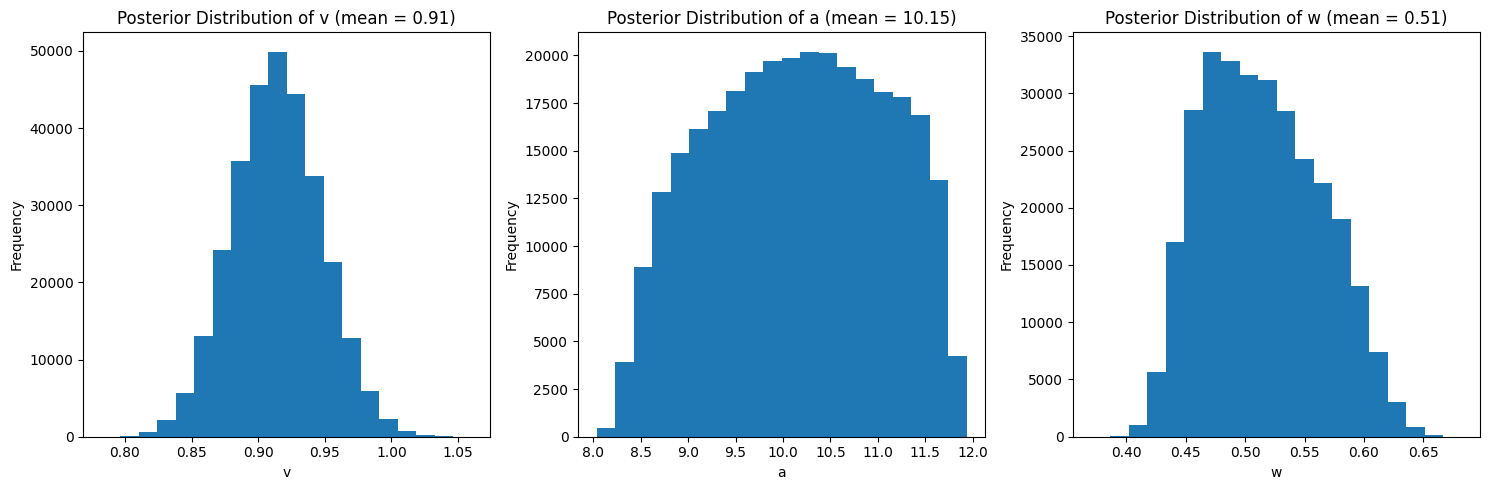

In [229]:
a_c, _ = vp.sample(int(3e5))
v_post = a_c[:,0]
a_post = a_c[:,1]
w_post = a_c[:,2]

plt.figure(figsize=(15, 5))
plt.subplot(1, 3, 1)
plt.hist(v_post, bins=20)
plt.title(f'Posterior Distribution of v (mean = {np.mean(v_post):.2f})')
plt.xlabel('v')
plt.ylabel('Frequency')

plt.subplot(1, 3, 2)
plt.hist(a_post, bins=20)
plt.title(f'Posterior Distribution of a (mean = {np.mean(a_post):.2f})')
plt.xlabel('a')
plt.ylabel('Frequency')

plt.subplot(1, 3, 3)
plt.hist(w_post, bins=20)
plt.title(f'Posterior Distribution of w (mean = {np.mean(w_post):.2f})')
plt.xlabel('w')
plt.ylabel('Frequency')

plt.tight_layout()
plt.show()
